In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### **Introduction**

There is something inherently captivating about property tax data: behind the numbers lie insights into fiscal policies, property valuation trends, and even community structure. In this notebook, I set out on an exploratory journey with the 2024 Property Tax Roll dataset.

I will perform exploratory data analysis, visualize key relationships, handle missing data gracefully (a common stumbling block for many notebook creators), and build a predictive model to understand the relationship between assessed value and taxes.

### 📌 Problem Description

Property tax data is rich with financial, geographic, and policy insights. This notebook investigates how well a property's **assessed value** predicts its **total tax liability**, and highlights preprocessing challenges commonly faced when working with real-world fiscal data.

---

### 🔍 Key Steps in the Project

- **Data Cleaning**
  - Identified and addressed missing values, especially in critical prediction features like `TOTAL_ASSMT` and `TOTAL_TAXES`.
  - Dropped rows with NaNs to ensure model compatibility, with discussion of future alternatives like imputation.

- **Exploratory Data Analysis**
  - Plotted distributions of `TOTAL_ASSMT` and `TOTAL_TAXES`
  - Created a correlation heatmap and pairplot to analyze relationships between numerical variables

- **Predictive Modeling**
  - Built a simple **Linear Regression model** to predict `TOTAL_TAXES` from `TOTAL_ASSMT`
  - Split data into training and testing sets
  - Evaluated performance and discussed model limitations

- **Error Handling & Modeling Challenges**
  - Discussed how scikit-learn models like `LinearRegression` fail on missing values
  - Suggested alternatives for future work, including:
    - Using imputation (`SimpleImputer`)
    - Trying robust models like `HistGradientBoostingRegressor` that support NaNs

---

### 🤖 Model Used

- **Linear Regression**
  - Simple and interpretable
  - Effective for understanding baseline performance
  - Performance can be improved by using more advanced models in future iterations


In [7]:
# Suppress warnings and set up matplotlib
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set backend for matplotlib if needed
plt.switch_backend('Agg')  # Use Agg for non-interactive backend

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer

# Set visualization style
sns.set(style="whitegrid")

### Data loading and Exploration

In [8]:
file_path = '/kaggle/input/2024-property-tax-roll/2024_Property_Tax_Roll.csv'
df = pd.read_csv('2024_Property_Tax_Roll.csv')

In [9]:
df.head()

,P_ID,TAX_MAP,plat,lot,unit,CLASS,SHORT_DESC,LEVY_CODE_1,SHORT_DESC 1,CIVIC,...,STREET 1,S_SUFFIX,UNIT,CITY 1,STATE,ZIP_POSTAL 1,TOTAL_ASSMT,TOTAL_EXEMPT,TOTAL_TAXES,Property_Location
0,12.0,000-0001-0022,0.0,1.0,0022,10.0,Utility,C01,C01,NaN,...,NaN,NaN,NaN,Addison,TX,75001,6160000.0,0.0,216216.00,POINT (-71.412747 41.824461)
1,807.0,005-0514-0000,5.0,514.0,0000,1.0,Single Family,OO01,OO01,135.0,...,ABBOTT,ST,NaN,PROVIDENCE,RI,02906-1818,436900.0,47708.0,4070.76,POINT (-71.402954036 41.842866001)
2,69878.0,077-0893-0000,77.0,893.0,0000,1.0,Single Family,OO01,OO01,36.0,...,Wilna,St,NaN,Providence,RI,02904,322600.0,0.0,3374.24,POINT (-71.415484981 41.858035988)
3,2050.0,008-0350-0000,8.0,350.0,0000,1.0,Single Family,OO01,OO01,120.0,...,Morris,Ave,NaN,PROVIDENCE,RI,02906-3040,572100.0,57364.0,5383.88,POINT (-71.398264026 41.83631701)
4,5030.0,016-0560-0000,16.0,560.0,0000,1.0,Single Family,OO01,OO01,22.0,...,John,St,NaN,Providence,RI,02906,643000.0,0.0,6725.48,POINT (-71.400355981 41.821832998)


In [10]:
# Basic information about the dataset
print('Dataset Shape:', df.shape)
print('\nColumns:')
print(df.columns.tolist())

# Overview of data types and missing values
df.info()
print('\nMissing Values Per Column:')
print(df.isna().sum())

Dataset Shape: (44034, 30)

Columns:
['P_ID', 'TAX_MAP', 'plat', 'lot', 'unit', 'CLASS', 'SHORT_DESC', 'LEVY_CODE_1', 'SHORT_DESC 1', 'CIVIC', 'STREET', 'SUFFIX', 'FORMATED_ADDRESS', 'CITY', 'ZIP_POSTAL', 'FIRST_NAME', 'LAST_NAME', 'COMPANY', 'FREE_LINE_2', 'CIVIC 1', 'STREET 1', 'S_SUFFIX', 'UNIT', 'CITY 1', 'STATE', 'ZIP_POSTAL 1', 'TOTAL_ASSMT', 'TOTAL_EXEMPT', 'TOTAL_TAXES', 'Property_Location']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44034 entries, 0 to 44033
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   P_ID               44033 non-null  float64
 1   TAX_MAP            44033 non-null  object 
 2   plat               44033 non-null  float64
 3   lot                44033 non-null  float64
 4   unit               44033 non-null  object 
 5   CLASS              44033 non-null  float64
 6   SHORT_DESC         44033 non-null  object 
 7   LEVY_CODE_1        44033 non-null  object 
 8   SHO

**Data Cleaning and Preprocessing**

Before diving into the exploratory visualizations and building our prediction model, it is important to address any data quality issues. The error encountered during model evaluation was due to missing values (NaN) present in the input features. In this section we handle missing values by dropping rows for our prediction columns or alternatively, using imputation. Here we demonstrate a simple approach for the columns we care about: TOTAL_ASSMT and TOTAL_TAXES.

In [11]:
# Focus on the numeric columns needed for modeling
numeric_cols = ['TOTAL_ASSMT', 'TOTAL_TAXES']
df_model = df[numeric_cols].copy()

# Check for missing values in these columns
print('Missing values in model data:')
print(df_model.isna().sum())

# Handle missing values
df_model.dropna(inplace=True)
print('\nShape after handling missing values:', df_model.shape)

Missing values in model data:
TOTAL_ASSMT    1
TOTAL_TAXES    1
dtype: int64

Shape after handling missing values: (44033, 2)


**Exploratory Data Analysis**

In this section we explore the numerical distributions and relationships between key variables. With several numerical columns at hand, a correlation heatmap can reveal underlying patterns.

Below, we visualize the distribution of assessed values and taxes, and also plot a pair plot to observe pairwise relationships.

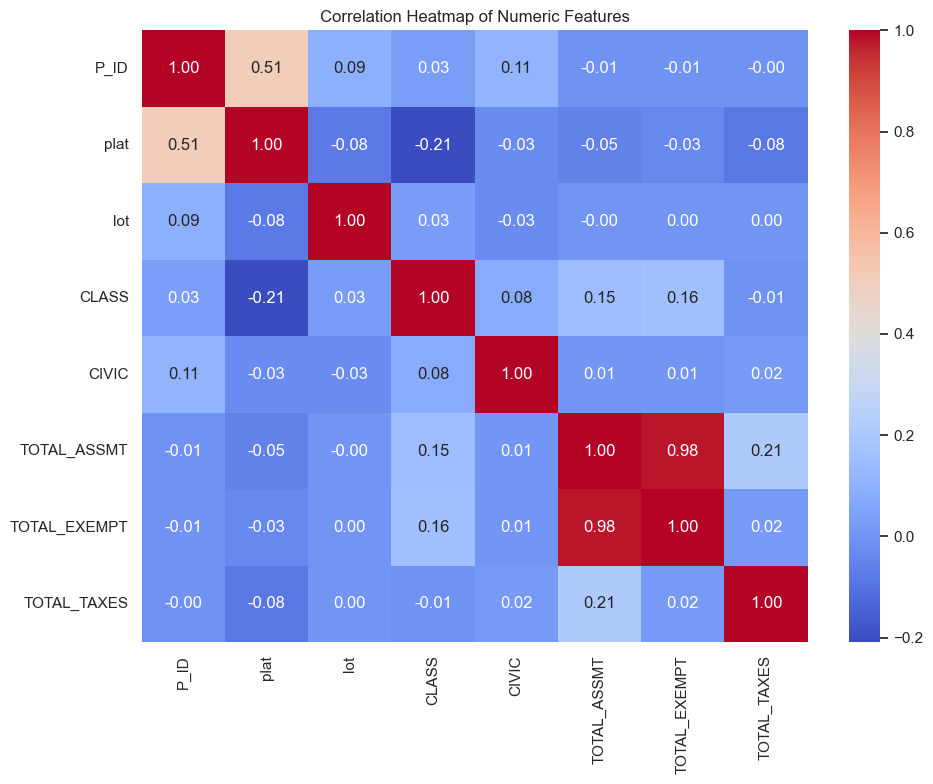

In [12]:
# Select numeric data for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])

# Only plot correlation heatmap if we have 4 or more numeric columns
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

Pair plot for numeric features of interest

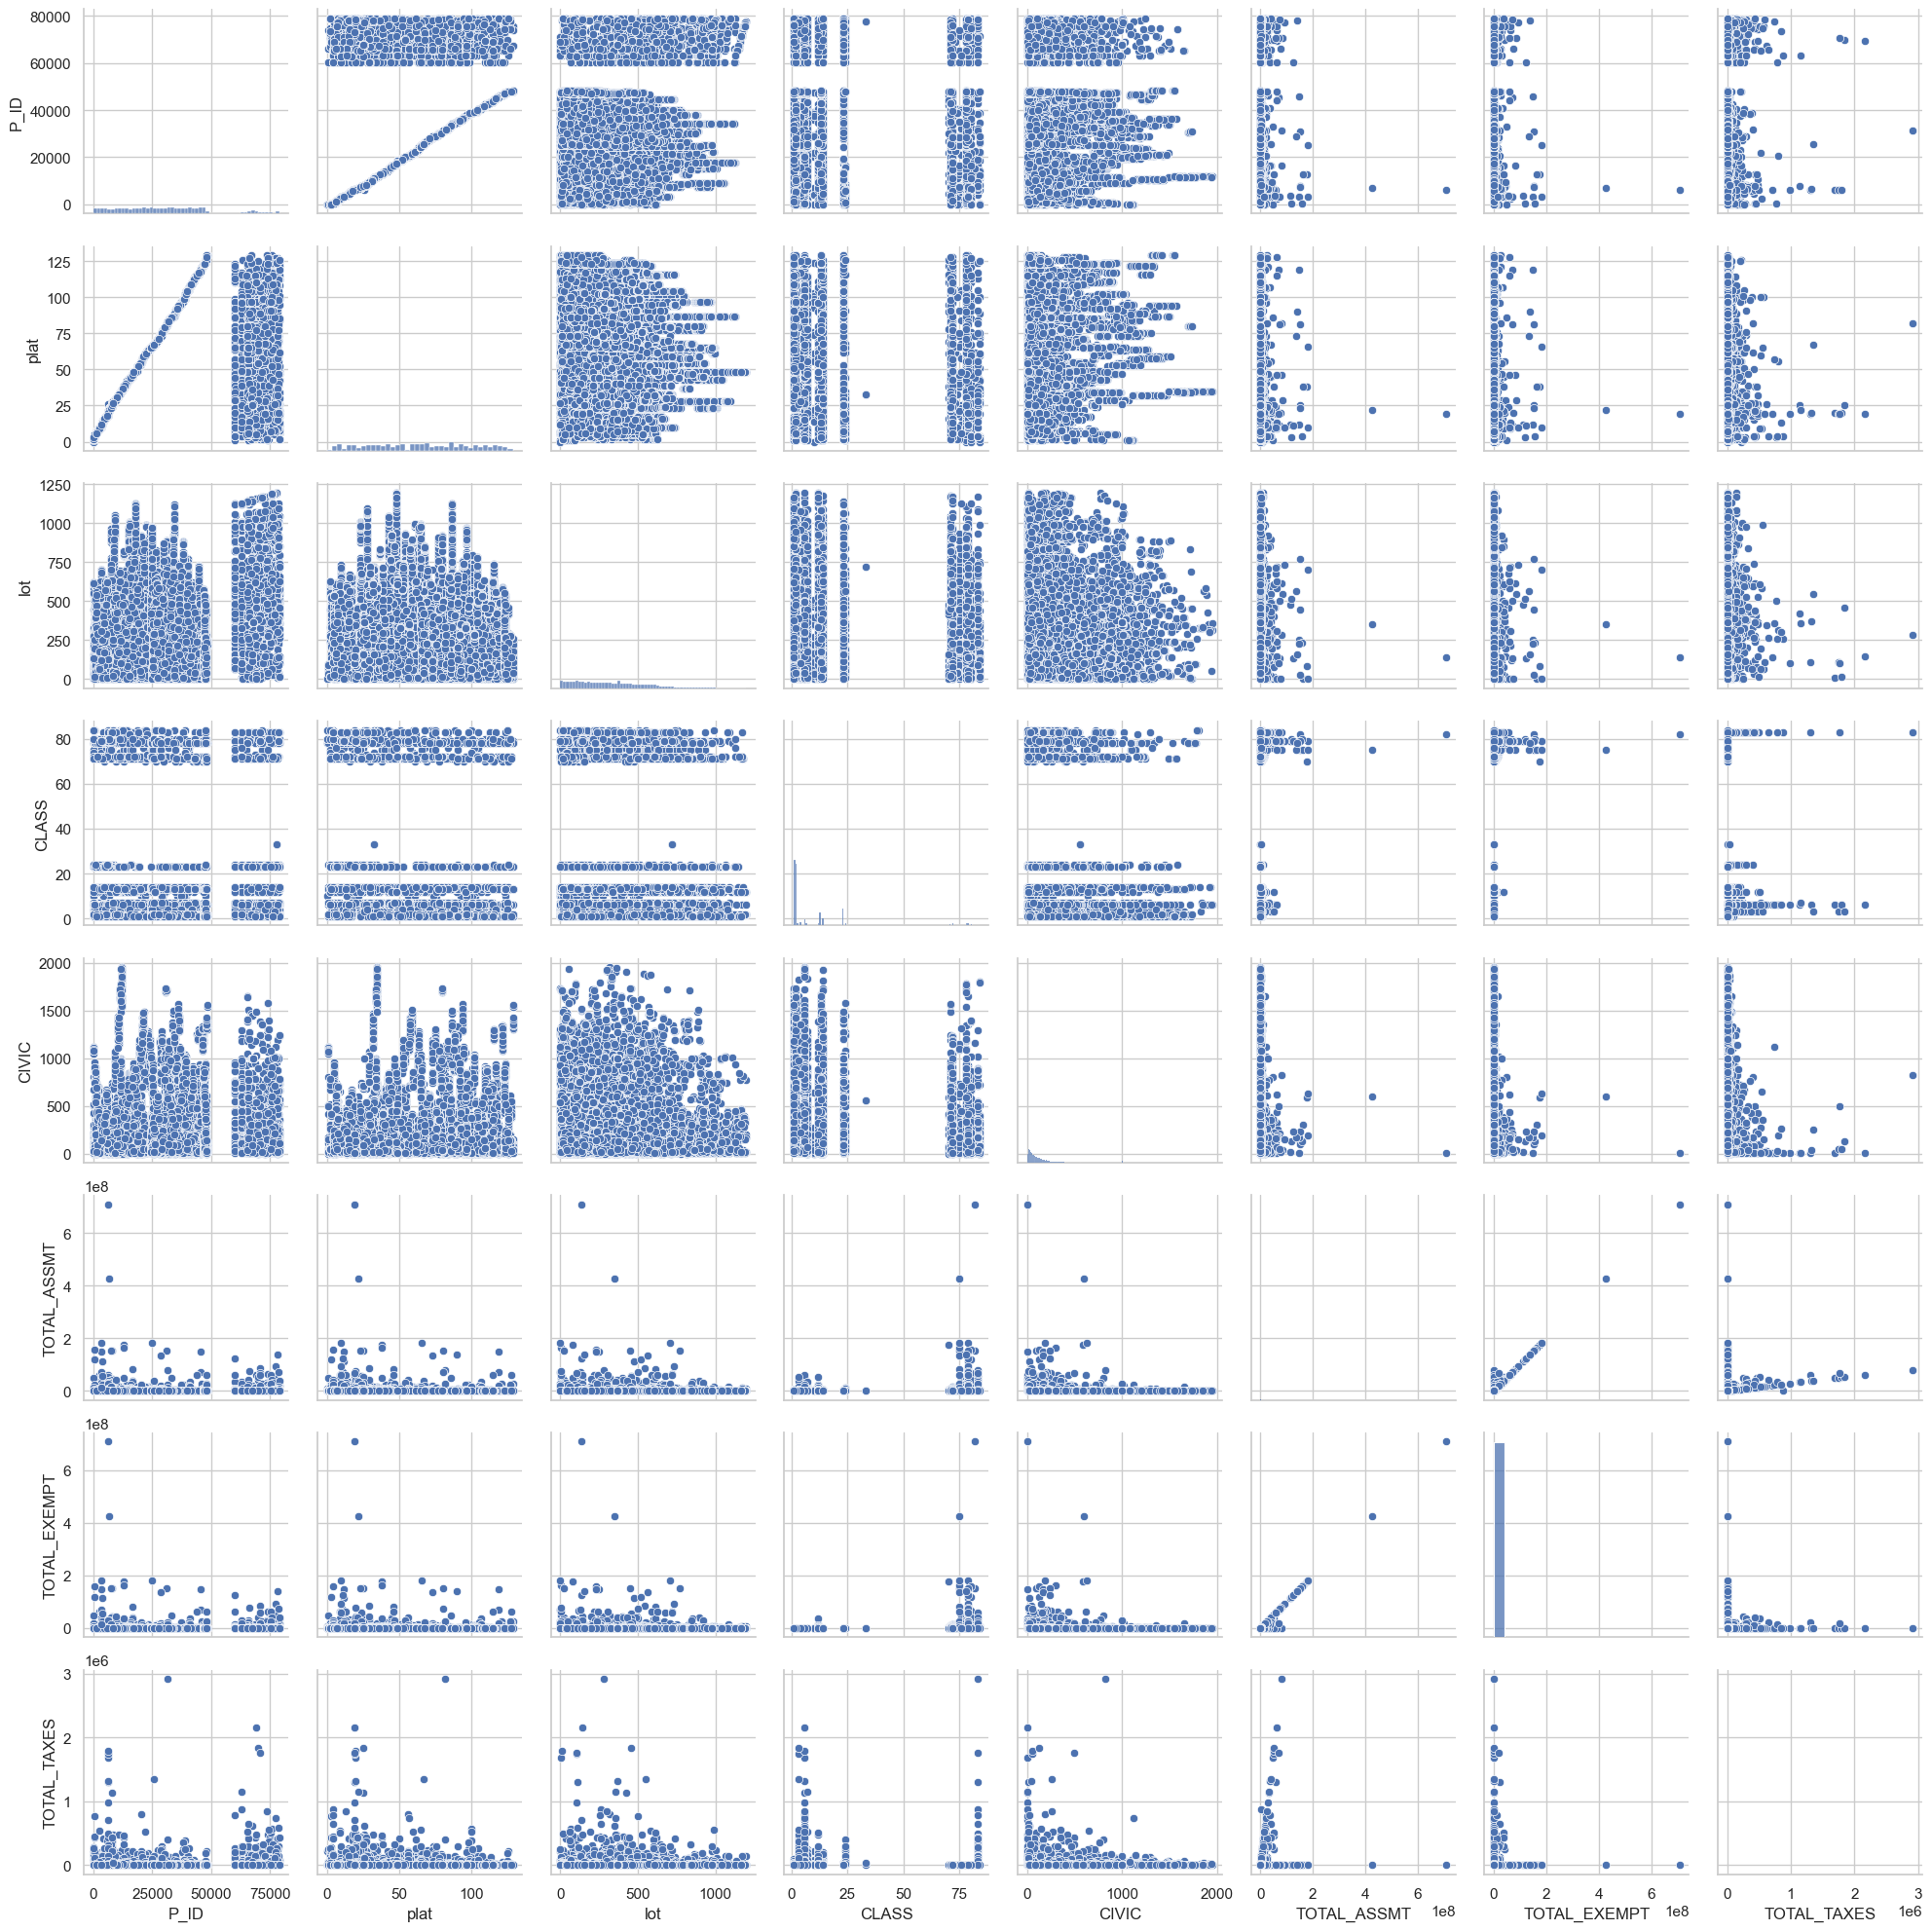

In [13]:
sns.pairplot(numeric_df)
plt.tight_layout()
plt.show()

**Modeling and Prediction**

We now turn our attention to building a simple predictive model. Specifically, we design a linear regression model to predict TOTAL_TAXES based on TOTAL_ASSMT. This straightforward approach offers insights into how well the assessed value explains the taxes levied.

We begin by splitting our data into training and testing sets. It is crucial to note that handling missing values in our input features is a common hurdle. As demonstrated earlier, we dropped rows with missing values to avoid errors such as those encountered during the notebook conversion process. Future implementations might reconsider imputation strategies or more advanced modeling techniques that naturally handle missing data.

R² Score: -0.007967712585346787
Root Mean Squared Error (RMSE): 28252.7322288011


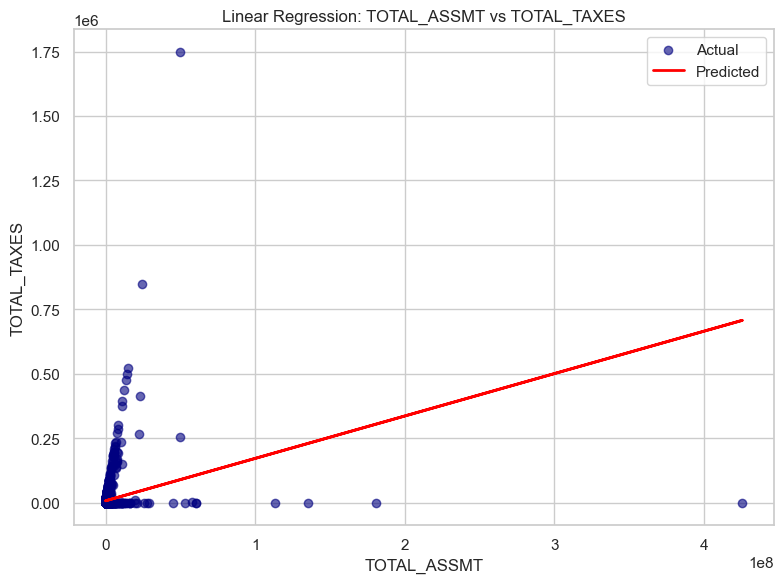

In [14]:
# Define predictor and target variables
X = df_model[['TOTAL_ASSMT']]
y = df_model['TOTAL_TAXES']

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate on testing data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R² Score:', r2)
print('Root Mean Squared Error (RMSE):', rmse)

# Visualize the regression fit
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='navy', alpha=0.6, label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('TOTAL_ASSMT')
plt.ylabel('TOTAL_TAXES')
plt.title('Linear Regression: TOTAL_ASSMT vs TOTAL_TAXES')
plt.legend()
plt.tight_layout()
plt.show()

**Challenges Encountered**

A notable challenge that surfaced during model evaluation was the presence of missing values in input features. The LinearRegression model from scikit-learn does not natively handle NaN values, which triggered an error when calling the predict method.

To resolve this, we opted to drop the rows with missing values for the key predictor and target variables. Alternative methods include utilizing an imputer (such as SimpleImputer with a median strategy) or adopting models like HistGradientBoostingRegressor that accept NaN values natively. This is a common issue that may perplex many new explorers of machine learning, so it is beneficial to be aware of data preprocessing best practices.

**Conclusion and Future Work**

In this notebook, we embarked on an exploratory analysis of property tax data, visualized the underlying distributions and correlations of key features, and built a basic linear regression model to predict tax liabilities. The approach taken here, including early detection and resolution of missing value issues, is crucial for ensuring robust model performance.